<a href="https://colab.research.google.com/github/AloofBuddha/NVDLI/blob/main/01_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification with the MNIST Dataset

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

In [2]:
# triton needed as an explicit install
!pip install triton
!pip install --upgrade torch triton

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## Exploring the MNIST Data

Train / Validate split

In [4]:
# this will download the datasets if not already installed
train_set = torchvision.datasets.MNIST("./data/", train=True, download=True)
valid_set = torchvision.datasets.MNIST("./data/", train=False, download=True)
len(train_set), len(valid_set)

(60000, 10000)

We are trying to map a 28x28 image to a single int label

In [5]:
x_0, y_0 = train_set[0]
x_0, type(x_0), x_0.size

(<PIL.Image.Image image mode=L size=28x28>, PIL.Image.Image, (28, 28))

In [6]:
y_0, type(y_0)

(5, int)

let's see what an image actually looks like in raw: 26x26 array of pixels with values 0-225 (grayscale)

In [7]:
# view the image in raw as an array
x_0_df = pd.DataFrame(np.array(x_0))
x_0_df.style.background_gradient(cmap="Grays")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0


As an image with label

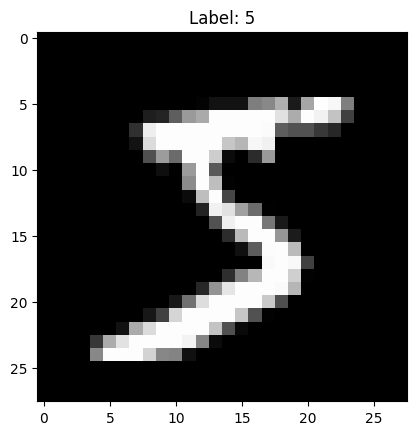

In [8]:
plt.title(f"Label: {y_0}")
plt.imshow(x_0, cmap='gray')

Our basic task is first to create a mapping from an iamge to the associated label

### Convert to Tensors

Tensors are a data type that generalized on n-dim arrays and is well optimized for working with GPUs

In [9]:
trans = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])
x_0_tensor = trans(x_0)
x_0_tensor.dtype

torch.float32

In [10]:
# min max is now 0-1, as the values from 0-255 have been normalized
x_0_tensor.min(), x_0_tensor.max()

(tensor(0.), tensor(1.))

In [11]:
# let's see this with pd
x_0_tensor_df = pd.DataFrame(x_0_tensor.numpy()[0])
x_0_tensor_df.style.format("{:.2f}").background_gradient(cmap="Grays")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.69,0.10,0.65,1.00,0.97,0.50,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.67,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76,0.25,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.78,0.71,0.97,0.95,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [12]:
# will run on a GPU if available, otherwise CPU
x_0_gpu = x_0_tensor.to(device)
x_0_gpu.device

device(type='cuda', index=0)

## Preparing the Data for Training

In [13]:
train_set.transform = trans
valid_set.transform = trans

In [14]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size)

## Creating the Model

In [15]:
# we will build up our layers incrementally
layers = []
layers

[]

### Flattening the images

(color x height x width) => 1d value

In [16]:
# example: represents 2 example (batch size 2) of a 3 x 3 matrix, ie 2 x 3 x 3
test_batch = torch.tensor(
    [[[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]],
     [[11, 12, 13],
     [14, 15, 16],
     [17, 18, 19]]]
)
test_batch, test_batch.size()

(tensor([[[ 1,  2,  3],
          [ 4,  5,  6],
          [ 7,  8,  9]],
 
         [[11, 12, 13],
          [14, 15, 16],
          [17, 18, 19]]]),
 torch.Size([2, 3, 3]))

In [17]:
# flatted to 2 x 9
flattened_test_batch = nn.Flatten()(test_batch)
flattened_test_batch, flattened_test_batch.size()

(tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9],
         [11, 12, 13, 14, 15, 16, 17, 18, 19]]),
 torch.Size([2, 9]))

In [18]:
# first layer flattens
layers = [
    nn.Flatten()
]
layers

[Flatten(start_dim=1, end_dim=-1)]

In [19]:
# corresponds to a length of a single flattened input which is a scalar (color) * width * height
input_size = 1 * 28 * 28

In [20]:
# this would be the basics.
# Flatten transforms the data into a something 1D
# our first real layer sends 1*28*28 (784) values representing the image to 512 neurons (magic # for rn)
# activation introduces non-linearity
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU()]

In [21]:
# hidden layer added, plus activiation
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU()  # Activation for hidden
]
layers

[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU()]

In [22]:
# 10 possible output classes 0-9, transform at final layer
n_classes = 10

# 784 -> 512 -> 512 -> 10
layers = [
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
]
layers


[Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=784, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=512, bias=True),
 ReLU(),
 Linear(in_features=512, out_features=10, bias=True)]

In [23]:
model = nn.Sequential(*layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [24]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)

In [25]:
next(model.parameters()).device

device(type='cuda', index=0)

In [26]:
model = torch.compile(model)

## Training

In [27]:
# don't understand this well yet but the loss function 'grades' a given guess (given x_0, guesses 2)
loss_function = nn.CrossEntropyLoss()
# the optimizer tells the model how to learn from the loss function
optimizer = Adam(model.parameters())

### Metrics

In [28]:
train_N = len(train_loader.dataset)
valid_N = len(valid_loader.dataset)

train_N, valid_N

(60000, 10000)

In [29]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### The training fn

In [30]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### The validate fn

In [31]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### The training loop

In [32]:
# how many times we want to run the sequence
epochs = 5

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 373.5234 Accuracy: 0.9391
Valid - Loss: 28.3719 Accuracy: 0.9732
Epoch: 1
Train - Loss: 159.5825 Accuracy: 0.9743
Valid - Loss: 28.6781 Accuracy: 0.9701
Epoch: 2
Train - Loss: 105.5471 Accuracy: 0.9822
Valid - Loss: 24.5483 Accuracy: 0.9773
Epoch: 3
Train - Loss: 82.6276 Accuracy: 0.9858
Valid - Loss: 26.7602 Accuracy: 0.9759
Epoch: 4
Train - Loss: 66.7059 Accuracy: 0.9886
Valid - Loss: 22.9656 Accuracy: 0.9794


In [33]:
prediction = model(x_0_gpu)
prediction

tensor([[-18.6333,  -5.1424, -12.1185,  10.0179, -26.2992,  17.0218, -15.6182,
         -19.8077, -12.9789,  -5.1279]], device='cuda:0',
       grad_fn=<AddmmBackward0>)